In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os 
import math
from scipy import interpolate

In [2]:
def ExtractPeriod(ModelDirectory):
    os.chdir(ModelDirectory)
    return  np.loadtxt('periods.out')

In [50]:
def pushoverdata(ModelDirectory, Direction, Story, w, NumStory):
    Results = []
    BaseDirectory = ModelDirectory + 'Static-Pushover-Output-Model3D-' + Direction + 'PushoverDirection'
    BRDirectory = BaseDirectory + '\\BaseReactions\\'
    os.chdir(BRDirectory) # Change working directory to base reaction folder
    NodeBS = np.loadtxt(r'LeaningColumnBaseNode' + Direction + 'HorizontalReactions.out') 
    
    if min(NodeBS[:,0]) < 0:
        idx = [ n for n,i in enumerate(NodeBS[:,0]) if i < 0 ][0]
    else: idx = NodeBS.shape[0]

    NodeBS = NodeBS[0:idx,:]
    PanelBS = np.loadtxt(Direction + 'PanelBaseNodesHorizontalReactions.out') 
    PanelBS = PanelBS[0:idx,:]
    
    os.chdir(BaseDirectory)
    
    if os.path.isdir('./MFBaseReactions'):
        os.chdir('MFBaseReactions')
        if os.path.isfile('%sMFBaseNodesHorizontalReactions.out'%Direction):
            MFBS = np.loadtxt('%sMFBaseNodesHorizontalReactions.out'%Direction)
            MFBS = MFBS[0:idx,:]
            BR = np.asarray(np.sum(NodeBS[:,1:NodeBS.shape[1]]/w,axis=1).tolist() ) + np.sum(PanelBS[:,1:PanelBS.shape[1]]/w,axis=1).tolist() + np.sum(MFBS[:,1:MFBS.shape[1]]/w,axis=1).tolist()
        else: BR = np.asarray(np.sum(NodeBS[:,1:NodeBS.shape[1]]/w,axis=1).tolist() ) + np.sum(PanelBS[:,1:PanelBS.shape[1]]/w,axis=1).tolist()
    else: 
        BR = np.asarray(np.sum(NodeBS[:,1:NodeBS.shape[1]]/w,axis=1).tolist() ) + np.sum(PanelBS[:,1:PanelBS.shape[1]]/w,axis=1).tolist()
    
    Results.append(np.abs(BR))# Only base shear of master node should be considered, here the master node is center leaning column
    
    SDRDirectory = BaseDirectory + '\\StoryDrifts'
    os.chdir(SDRDirectory)
    DR = np.abs(np.loadtxt(r'LeaningColumn' + Direction + 'Drift.out'))
    DR = DR[0:idx,:]
    if str(Story) == 'roof': # roof drift ratio
        if NumStory == 1:
            Results.append(DR[:,4])
        else: Results.append(DR[:,-1])
            
    else: Results.append(DR[:,(Story-1)*3+1])
        
    return Results


def extractpushoverpoints(Results):
    peakstrength = np.max(Results[0])
    driftpeakstrength = Results[1][Results[0] == peakstrength][0]
    
    peakstregth_idx = Results[0].argmax()
    
    elasticStrength = Results[0][0:peakstregth_idx]
    elasticDrift = Results[1][0:peakstregth_idx]
    plasticStrength = Results[0][peakstregth_idx : -1]
    plasticDrift = Results[1][peakstregth_idx : -1]
    
    idx = (np.abs(elasticStrength - 0.8 * peakstrength)).argmin()
    elasticDrift_critical = elasticDrift[idx]
    elasticStrength_critical = elasticStrength[idx]
    
    idx = (np.abs(plasticStrength - 0.8 * peakstrength)).argmin()
    plasticDrift_critical = plasticDrift[idx]
    plasticStrength_critical = plasticStrength[idx]
    
    idx = (np.abs(plasticStrength - peakstrength)).argmin()
    totalidx = peakstregth_idx + idx 
    area = np.trapz(Results[0][0:totalidx], x = Results[1][0:totalidx])
    
    return peakstrength, driftpeakstrength, elasticDrift_critical, plasticDrift_critical, area
    
    

In [5]:
BaseDirectory = r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingModels\\'

os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\RootModule')
with open('BuildingName.txt', 'r') as file:
    BuildingName = file.read()
    
BuildingName = BuildingName.split('\n')

NumStory = []
SeismicWeight = []

for i in range(len(BuildingName)):
    os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingData\%s\Geometry'%BuildingName[i])
    NumStory.append(int(np.sum(np.loadtxt('numberOfStories.txt'))))
    os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingData\%s\Loads'%BuildingName[i])
    file = np.loadtxt('floorWeights.txt')
    SeismicWeight.append(np.sum(file))

In [11]:
period = []
for i in range(len(BuildingName)):
    period.append(ExtractPeriod(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingModels\%s\OpenSees3DModels\EigenValueAnalysis\Analysis_Results\Modes'%BuildingName[i]))

In [13]:
os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign')
Period = pd.DataFrame(data = period)


In [53]:
PushoverResultsX = pd.DataFrame(columns = ['NumStory','SeismicWeight','peakstrength','drift@peakstrength','drift@80%peakstrength','drift@20%residualstrength','area'],
                            index = BuildingName)
PushoverResultsZ = pd.DataFrame(columns = ['NumStory','SeismicWeight','peakstrength','drift@peakstrength','drift@80%peakstrength','drift@20%residualstrength','area'],
                            index = BuildingName)
PushoverResultsX['NumStory'] = NumStory
PushoverResultsX['SeismicWeight'] = SeismicWeight
PushoverResultsZ['NumStory'] = NumStory
PushoverResultsZ['SeismicWeight'] = SeismicWeight

for i in range(len(BuildingName)):

    PushoverX = pushoverdata(BaseDirectory + BuildingName[i]+'\OpenSees3DModels\PushoverAnalysis\\', 'X', 'roof', 
                             PushoverResultsX['SeismicWeight'][i], int(PushoverResultsX['NumStory'][i]))

    PushoverZ = pushoverdata(BaseDirectory + BuildingName[i]+'\OpenSees3DModels\PushoverAnalysis\\', 'Z', 'roof', 
                             PushoverResultsZ['SeismicWeight'][i], int(PushoverResultsZ['NumStory'][i]))

    PushoverResultsX.iloc[i,2:7] = extractpushoverpoints(PushoverX)
    PushoverResultsZ.iloc[i,2:7] = extractpushoverpoints(PushoverZ)

In [16]:
os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign')
PushoverResultsX.to_csv('PushoverX.csv')
PushoverResultsZ.to_csv('PushoverZ.csv')

Text(0,0.5,'Normalized Base Shear (V/W)')

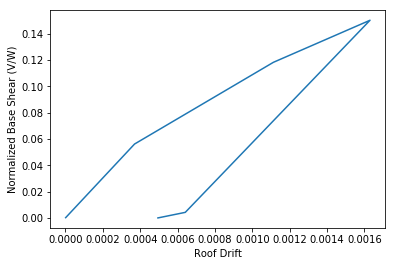

In [15]:
plt.plot(PushoverZ[1],PushoverZ[0])

plt.xlabel('Roof Drift')
plt.ylabel('Normalized Base Shear (V/W)')

In [29]:
PushoverX_Existing = pushoverdata(BaseDirectory + BuildingName[0]+'\OpenSees3DModels\PushoverAnalysis\\', 'X', 'roof', 
                             SeismicWeight[0], int(NumStory[0]))

PushoverResultsX_Existing = extractpushoverpoints(PushoverX_Existing)

PushoverX_Ordinance = pushoverdata(BaseDirectory + BuildingName[32]+'\OpenSees3DModels\PushoverAnalysis\\', 'X', 'roof', 
                             SeismicWeight[32], int(NumStory[32]))
PushoverResultsX_Ordinance = extractpushoverpoints(PushoverX_Ordinance)

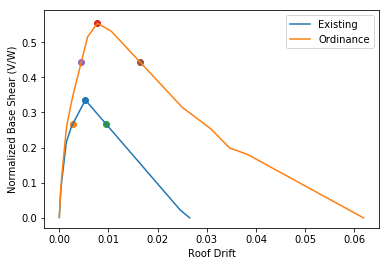

In [30]:
plt.plot(PushoverX_Existing[1],PushoverX_Existing[0],label = 'Existing')
plt.plot(PushoverX_Ordinance[1],PushoverX_Ordinance[0], label = 'Ordinance')

plt.scatter(PushoverResultsX_Existing[1],PushoverResultsX_Existing[0])
plt.scatter(PushoverResultsX_Existing[2], 0.8*PushoverResultsX_Existing[0])
plt.scatter(PushoverResultsX_Existing[3], 0.8*PushoverResultsX_Existing[0])

plt.scatter(PushoverResultsX_Ordinance[1],PushoverResultsX_Ordinance[0])
plt.scatter(PushoverResultsX_Ordinance[2], 0.8*PushoverResultsX_Ordinance[0])
plt.scatter(PushoverResultsX_Ordinance[3], 0.8*PushoverResultsX_Ordinance[0])
plt.xlabel('Roof Drift')
plt.ylabel('Normalized Base Shear (V/W)')
plt.legend()

# Modify eigen analysis file

In [17]:
for i in range(len(BuildingName)):
    os.chdir(BaseDirectory + BuildingName[i]+'\OpenSees3DModels\EigenValueAnalysis\\')
    tclfile = open('EigenValueAnalysis.tcl','a+')
    
    for j in range(4):
        tclfile.write('set mode_file [open $recorderdir/mode_shape%i.out w];\n'%(j+1))
        tclfile.write('puts $mode_file "[nodeEigenvector 2000 %i]"\n'%(j+1))
        tclfile.write('puts $mode_file "[nodeEigenvector 3000 %i]"\n'%(j+1))
        
        if NumStory[i] == 3:
            tclfile.write('puts $mode_file "[nodeEigenvector 4000 %i]"\n'%(j+1))
        tclfile.write('close $mode_file')    
        tclfile.write('\n\n')
        
    tclfile.write('puts "mode shape done!"')
    tclfile.close()
            
        
    
    

# Period-Based Ductility Coefficient

In [54]:
C0X = []
C0Z = []
for i in range(1,2):
    os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingModels\%s\OpenSees3DModels\EigenValueAnalysis\Analysis_Results\Modes'%BuildingName[i])
    mode_shape = np.loadtxt('mode_shape1.out')
    
    os.chdir(r'C:\Users\User\Desktop\20190705OrdinanceRedesign\BuildingData\%s\Loads'%BuildingName[i])
    story_mass = np.loadtxt('floorWeights.txt')/386.4
    
    mode1 = mode_shape[:,0]
    mode2 = mode_shape[:,2]

    C0X.append(mode1[-1]*np.sum(np.multiply(mode1, story_mass))/np.sum(np.multiply(mode1**2, story_mass)))
    C0Z.append(mode2[-1]*np.sum(np.multiply(mode2, story_mass))/np.sum(np.multiply(mode2**2, story_mass)))
    
C0X = np.array(C0X)
C0Z = np.array(C0Z)

In [55]:
emperical_period = np.zeros([96,])
emperical_period[PushoverResultsX['NumStory'] == 2] = 0.249768
emperical_period[PushoverResultsX['NumStory'] == 3] = 0.338536

delta_yieldX = np.multiply(np.multiply(np.dot(C0X, 386.5/4/(math.pi)**2), PushoverResultsX['peakstrength']),np.max([emperical_period,Period.iloc[:,0].values], axis = 0)**2)
delta_yieldZ = np.multiply(np.multiply(np.dot(C0Z, 386.5/4/(math.pi)**2), PushoverResultsZ['peakstrength']),np.max([emperical_period,Period.iloc[:,0].values], axis = 0)**2)



In [56]:
PushoverResultsX

,NumStory,SeismicWeight,peakstrength,drift@peakstrength,drift@80%peakstrength,drift@20%residualstrength,area
Building_T1-60x30-S2-GS_Existing,2,184.605417,0.335198,0.00529209,0.00276778,0.0094404,0.00126813
Building_T1-60x30-S3-GS_Existing,3,306.148667,0.197338,0.00386127,0.00204165,0.00626705,0.000539809
Building_T1-100x30-S2-GS_Existing,2,284.023958,0.436564,0.00545675,0.00291305,0.00978324,0.00169411
Building_T1-100x30-S3-GS_Existing,3,467.476292,0.260454,0.00406687,0.0022275,0.00663044,0.000741431
Building_T1-60x30-S2-PS_Existing,2,184.605417,0.262061,0.00538123,0.00331305,0.0128631,0.000974386
Building_T1-60x30-S3-PS_Existing,3,306.148667,0.15325,0.00396236,0.00242626,0.00782282,0.000416604
Building_T1-100x30-S2-PS_Existing,2,284.023958,0.343384,0.00554012,0.00344133,0.0136957,0.00130629
Building_T1-100x30-S3-PS_Existing,3,467.476292,0.203842,0.00419827,0.00263245,0.00858237,0.000580404
Building_T2-60x50-S2-GS_Existing,2,286.820542,0.377547,0.00528203,0.00244816,0.00959457,0.00146601
Building_T2-60x50-S3-GS_Existing,3,469.369458,0.224495,0.00452883,0.0020892,0.00704349,0.000739932


In [51]:
#for i in range(len(BuildingName)):
for i in range(1,2):

    PushoverX = pushoverdata(BaseDirectory + BuildingName[i]+'\OpenSees3DModels\PushoverAnalysis\\', 'X', 'roof', 
                             PushoverResultsX['SeismicWeight'][i], int(PushoverResultsX['NumStory'][i]))

    PushoverZ = pushoverdata(BaseDirectory + BuildingName[i]+'\OpenSees3DModels\PushoverAnalysis\\', 'Z', 'roof', 
                             PushoverResultsZ['SeismicWeight'][i], int(PushoverResultsZ['NumStory'][i]))
    
    PushoverResultsXtemp = extractpushoverpoints(PushoverX)
    PushoverResultsZtemp = extractpushoverpoints(PushoverZ)
    
    stiffnessX = np.divide(np.diff(PushoverX[0]),np.diff(PushoverX[1]))
    stiffnessZ = np.divide(np.diff(PushoverZ[0]),np.diff(PushoverZ[1]))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


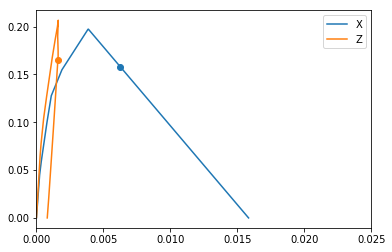

In [52]:
plt.plot(PushoverX[1],PushoverX[0],label = 'X')
plt.plot(PushoverZ[1],PushoverZ[0], label = 'Z')


plt.scatter(PushoverResultsXtemp[3],0.8*PushoverResultsXtemp[0])
plt.scatter(PushoverResultsZtemp[3],0.8*PushoverResultsZtemp[0])



plt.xlim([0,0.025])
plt.legend()

In [63]:
miu_T_X = np.array(np.multiply(PushoverResultsX['drift@20%residualstrength'], PushoverResultsX['NumStory']*111)/delta_yieldX, dtype = 'float64')
miu_T_Z = np.array(np.multiply(PushoverResultsZ['drift@20%residualstrength'], PushoverResultsZ['NumStory']*111)/delta_yieldZ, dtype = 'float64')

T = [0.5,0.6,0.7,0.8]

miu_T = [1.0,1.1,1.5,2,3,4,6,8]

SSF = [[1,1.02,1.04,1.06,1.08,1.09,1.12,1.14],[1.0,1.02,1.05,1.07,1.09,1.11,1.13,1.16],
       [1.0,1.03,1.06,1.08,1.10,1.12,1.15,1.18],[1.0,1.03,1.06,1.08,1.10,1.12,1.15,1.18]]

f = interpolate.interp2d(miu_T,T,SSF)

SSF_X = []
SSF_Z = []
for i in range(96):
    SSF_X.append(f(miu_T_X[i],Period.iloc[i,0])[0])
    SSF_Z.append(f(miu_T_Z[i],Period.iloc[i,0])[0])

In [73]:
temp = pd.DataFrame()
temp['BuildingName'] = BuildingName
temp['SSF'] = np.mean([SSF_X,SSF_Z], axis = 0)
os.chdir(r'C:\\Users\\User\\Desktop\\20190705OrdinanceRedesign')
temp.to_csv('ScalingFactor.csv',index = None)

In [254]:
np.mean()

[1.0840032310526468,
 1.004102167911889,
 1.0835339440615024,
 1.0235914831403796,
 1.0888572584956553,
 1.029881585735701,
 1.0898036868287695,
 1.03607100987616,
 1.0845822653305424,
 1.0313129217906676,
 1.0834218024761026,
 1.0333643157123364,
 1.095732600446603,
 1.0267593531541332,
 1.1029560279350779,
 1.0364130622330952,
 1.0817057381129056,
 1.0307776056029037,
 1.0815172225845666,
 1.0306307863643858,
 1.0896310039167183,
 1.0260985644052727,
 1.092479195801407,
 1.0300326281905552,
 1.0814952296559779,
 1.0306334126221919,
 1.0809571241628821,
 1.0301453448260585,
 1.0889575966977199,
 1.0251884859517437,
 1.089988070847398,
 1.0310045436648312,
 1.0868213424851478,
 1.0279422943097263,
 1.0872348701339938,
 1.029976801429674,
 1.1137195695836528,
 1.027038195830125,
 1.1048502662670816,
 1.0329051543701309,
 1.0822680386417265,
 1.0275510447221605,
 1.0823325538570145,
 1.0288112156157505,
 1.1014340713722126,
 1.0287197894976872,
 1.1045372863630718,
 1.0393495356972091,
 

In [72]:
%pwd

'C:\\Users\\User\\Desktop\\20190705OrdinanceRedesign\\BuildingData\\Building_T1-60x30-S3-GS_Existing\\Loads'